In [1]:
import os
import torch
import data
import utils
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
import config as cfg
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from xpbd_softbody_layer import XPBDStep
import pyvista as pv
import matplotlib.pyplot as plt
from xpbd_softbody import XPBDSoftbody

In [2]:
mesh, softbody = data.get_xpbd_grape()

torch.Size([600, 3])
torch.Size([1200, 3])


In [3]:
control_trajectory = np.array([[0.000224, 0.010794, -0.001233],
                               [0.000186, 0.008863, 0.002481],
                               [0.000208, 0.00664, 0.003521],
                               [0.000197, 0.004594, 0.004361],
                               [0.000208, 0.002349, 0.005903],
                               [0.000197, -0.00004, 0.006602],
                               [0.000208, -0.00204, 0.007502],
                               [0.000208, -0.00404, 0.008502]])

In [4]:
control_point = 31
target_point = 26

In [5]:
softbody.init_target_area(softbody.V[target_point], radius=1.5e-3)

target point connects to 19 vertices


In [6]:
softbody.target_list

[tensor([ 22,  26,  27,  28,  29,  30,  81,  82,  98,  99, 100, 110, 538, 539,
         552, 553, 554, 555, 567], device='cuda:0')]

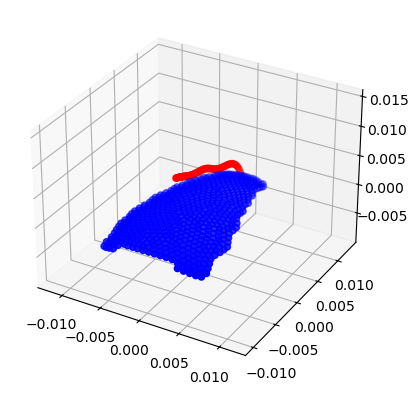

In [7]:
# interpolate trajectory
x = np.arange(control_trajectory.shape[0])
xnew = np.linspace(x.min(), x.max(), control_trajectory.shape[0]*10)  # 10 times denser
f = interp1d(x, control_trajectory, axis=0, kind='cubic')
control_trajectory = f(xnew)

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(control_trajectory[:, 0], control_trajectory[:, 1], control_trajectory[:, 2], c='r', marker='o')
ax.scatter(mesh.points[:600, 0], mesh.points[:600, 1], mesh.points[:600, 2], c='b', marker='o')
utils.axisEqual3D(ax)
# ax.view_init(elev=0, azim=0)
plt.show()

In [8]:
control_trajectory = torch.from_numpy(control_trajectory).to(cfg.device)
softbody.fix_point(0, control_point)

cloth_dist_stiffness = 1
V_boundary_stiffness = 0.1
V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)
V_boundary_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device) * V_boundary_stiffness

In [9]:
def get_energy_boundary(softbody: XPBDSoftbody,
                         V_predict: torch.Tensor,
                         V_boundary_stiffness: torch.Tensor,
                         mask: set = None) -> torch.Tensor:
    
    V_boundary_stiffness_threshold = V_boundary_stiffness.clone()
    # V_boundary_stiffness_threshold[V_boundary_stiffness_threshold < 1e-3] = 0
    V_boundary_stiffness_threshold = V_boundary_stiffness_threshold * torch.sigmoid(V_boundary_stiffness_threshold - 1e-3)


    dist_C, dist_C_stiffness = __get_spring_boundary_constraints(softbody,
                                                      V_predict,
                                                      V_boundary_stiffness_threshold,
                                                      mask)
    # energy is C^2 * stiffness / 2
    boundary_energy = torch.square(dist_C) * dist_C_stiffness / 2
    return boundary_energy

def __get_spring_boundary_constraints(softbody, V_predict, V_boundary_stiffness, mask=None):
    C = []
    C_stiffness = []
    # collect all distance constraints
    for C_dist, C_init_d in zip(softbody.C_boundary_list, softbody.C_init_boundary_d_list):
        if mask == None or (C_dist[:, 0] in mask and C_dist[:, 1] in mask):
            # position difference vectors
            N = V_predict[C_dist[:, 0]] - V_predict[C_dist[:, 1]]
            # distance
            D = torch.norm(N, p=2, dim=1, keepdim=True)
            # constarint values
            C.append(D - C_init_d)
            # average stiffness
            C_stiffness.append(V_boundary_stiffness[C_dist[:, 0]])
    return torch.cat(C), torch.cat(C_stiffness)

In [10]:
with torch.no_grad():
    for t in range(1, control_trajectory.shape[0]):
        softbody.V[control_point] = control_trajectory[t]

        step_ref = XPBDStep(softbody,
                        V_dist_stiffness=V_dist_stiffness, 
                        V_shape_stiffness=None,
                        V_boundary_stiffness=V_boundary_stiffness, 
                        dt=cfg.dt,
                        substep=cfg.substep,
                        iteration=cfg.iteration,
                        quasi_static=cfg.quasi_static,
                        plane_height=cfg.ground_plane_height, 
                        use_shape_matching=cfg.use_shape_matching,
                        use_spring_boundary=cfg.use_spring_boundary) #cfg.use_spring_boundary
        V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)
        softbody.V = V_ref.clone()
        softbody.V_velocity = V_velocity_ref.clone()

        energy = get_energy_boundary(softbody, softbody.V, V_boundary_stiffness)
        
        V_boundary_stiffness[:cfg.n_surf] = V_boundary_stiffness[:cfg.n_surf] * torch.sigmoid(1e9 * (1e-8 - energy))

        mesh.points = softbody.V.cpu().numpy()

In [11]:
control_line = control_trajectory.cpu().numpy()

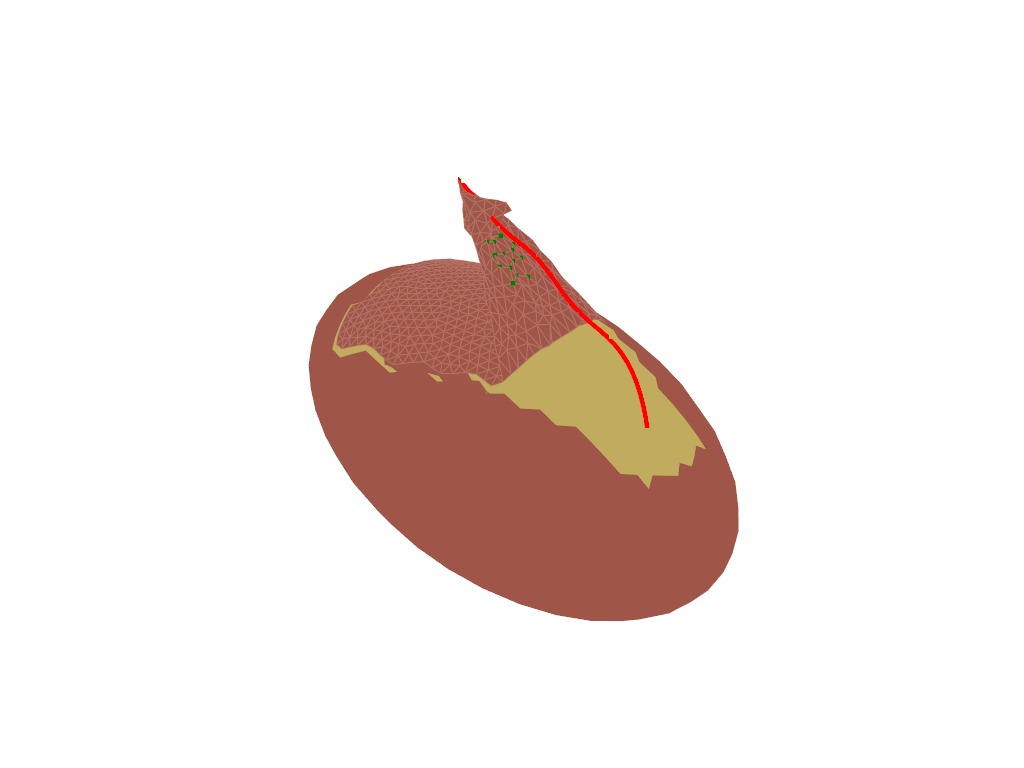

In [12]:
pv.set_plot_theme('document')
pl = pv.Plotter()

# skin being peeled
pl.add_mesh(mesh, color='#9f5547ff', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface')
# control line
pl.add_lines(control_line, color='r', connected=True)
# add target area
pl.add_points(mesh.points[softbody.target_list[0].cpu().numpy()], color='g')
# ellipsoid grape
grape = pv.read('assets/grape.ply')
grape.points = grape.points - np.array([0, 0, 1e-4])
pl.add_mesh(grape, color='#9f5547ff', show_edges=False, lighting=False,style='surface')

# grape meat that is green
grape_meat= pv.read('assets/grape_skin.ply')
grape_meat.points = grape_meat.points - np.array([0, 0, 2e-4])
pl.add_mesh(grape_meat, color='#c0ab5eff', show_edges=False, lighting=False,style='surface')
pl.show(jupyter_backend='static')
pl.clear()

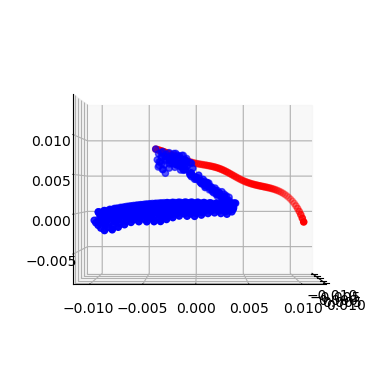

In [13]:
# interpolate trajectory
x = np.arange(control_trajectory.shape[0])
xnew = np.linspace(x.min(), x.max(), control_trajectory.shape[0]*10)  # 10 times denser

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(mesh.points[:600, 0], mesh.points[:600, 1], mesh.points[:600, 2], c='b', marker='o')
ax.scatter(control_trajectory[:, 0].cpu().numpy(), control_trajectory[:, 1].cpu().numpy(), control_trajectory[:, 2].cpu().numpy(), c='r', marker='o')
utils.axisEqual3D(ax)
ax.view_init(elev=0, azim=0)
plt.show()

In [14]:
target_mesh = mesh.copy()
target_trajectory = control_trajectory.cpu().numpy().copy()

In [15]:
target_pos = softbody.V[softbody.target_list].clone()

In [16]:
target_pos

tensor([[ 2.4242e-04,  6.4695e-04,  4.1690e-03],
        [ 2.0091e-04, -4.4762e-04,  5.1289e-03],
        [-1.5832e-04, -2.1686e-05,  4.6777e-03],
        [ 1.6860e-04, -1.8637e-03,  6.3563e-03],
        [ 2.2274e-05, -1.5550e-03,  5.7053e-03],
        [ 3.7900e-04, -1.0292e-03,  5.7450e-03],
        [-4.4679e-04,  8.8601e-04,  3.9213e-03],
        [-7.2055e-04,  5.1528e-05,  4.7065e-03],
        [-4.7342e-04, -4.4618e-04,  5.0817e-03],
        [-2.3289e-04, -1.0635e-03,  5.9009e-03],
        [-7.7002e-04, -5.9208e-04,  5.3072e-03],
        [-1.4542e-04, -2.1419e-03,  6.8640e-03],
        [ 8.5925e-04,  1.0158e-03,  4.1006e-03],
        [ 4.4491e-04,  3.1405e-04,  4.6345e-03],
        [ 9.4973e-04, -6.2238e-04,  5.0992e-03],
        [ 8.7214e-04, -3.4001e-05,  4.7331e-03],
        [ 7.4617e-04, -5.3732e-04,  5.2461e-03],
        [ 7.3474e-04, -1.2044e-03,  5.8037e-03],
        [ 6.5266e-04, -1.5940e-03,  6.4303e-03]], device='cuda:0')

In [17]:
mesh, softbody = data.get_xpbd_grape()
softbody.fix_point(0, control_point)
V_origin = softbody.V.clone()
Velocity_origin = softbody.V_velocity.clone()

torch.Size([600, 3])
torch.Size([1200, 3])


In [18]:
softbody.init_target_area(softbody.V[target_point], radius=1.5e-3)

target point connects to 19 vertices


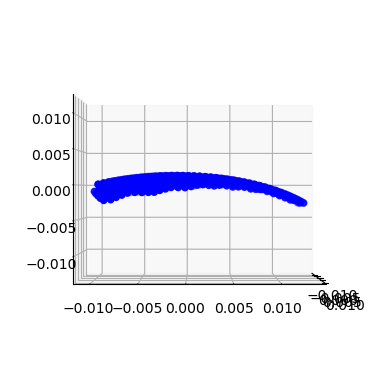

In [19]:
# interpolate trajectory
mesh.points = softbody.V.detach().cpu().numpy()
x = np.arange(control_trajectory.shape[0])
xnew = np.linspace(x.min(), x.max(), control_trajectory.shape[0]*10)  # 10 times denser

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(mesh.points[:600, 0], mesh.points[:600, 1], mesh.points[:600, 2], c='b', marker='o')
# ax.scatter(mesh.points[control_list, 0], mesh.points[control_list, 1], mesh.points[control_list, 2], c='r', marker='o')
# ax.scatter(mesh.points[target_list, 0], mesh.points[target_list, 1], mesh.points[target_list, 2], c='y', marker='o')
utils.axisEqual3D(ax)
ax.view_init(elev=0, azim=0)

In [20]:
# Hardcoded control trajectory
cloth_dist_stiffness = 1
V_boundary_stiffness = 0.1
V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)
V_boundary_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device) * V_boundary_stiffness

In [21]:
def loss_fn(target, predict):
    return torch.norm(target - predict)

In [22]:
u = torch.linspace(0, 1, 4).to(cfg.device)
us = torch.linspace(0, 1, 50).to(cfg.device)
start_point = np.array([[0.000224, 0.010794, -0.001233]])
start_point = torch.from_numpy(start_point).to(cfg.device)
spline_control = np.array([ [0.000224, 0.010794, 0.003],
                            [0.000224, 0.010794, 0.006],
                            [0.000224, 0.010794, 0.009]])
spline_control = torch.from_numpy(spline_control).to(cfg.device)
spline_control.requires_grad_(True)

tensor([[0.0002, 0.0108, 0.0030],
        [0.0002, 0.0108, 0.0060],
        [0.0002, 0.0108, 0.0090]], device='cuda:0', dtype=torch.float64,
       requires_grad=True)

In [23]:
optimizer = torch.optim.Adam([spline_control], lr=0.001)

In [24]:
def h_poly_helper(tt):
  A = torch.tensor([
      [1, 0, -3, 2],
      [0, 1, -2, 1],
      [0, 0, 3, -2],
      [0, 0, -1, 1]
      ], dtype=tt[-1].dtype)
  return [
    sum( A[i, j]*tt[j] for j in range(4) )
    for i in range(4) ]

def h_poly(t):
  tt = [ None for _ in range(4) ]
  tt[0] = 1
  for i in range(1, 4):
    tt[i] = tt[i-1]*t
  return h_poly_helper(tt)

def H_poly(t):
  tt = [ None for _ in range(4) ]
  tt[0] = t
  for i in range(1, 4):
    tt[i] = tt[i-1]*t*i/(i+1)
  return h_poly_helper(tt)

def interp_func(x, y):
  "Returns integral of interpolating function"
  if len(y)>1:
    m = (y[1:] - y[:-1])/(x[1:] - x[:-1])
    m = torch.cat([m[[0]], (m[1:] + m[:-1])/2, m[[-1]]])
  def f(xs):
    if len(y)==1: # in the case of 1 point, treat as constant function
      return y[0] + torch.zeros_like(xs)
    I = torch.searchsorted(x[1:], xs)
    dx = (x[I+1]-x[I])
    hh = h_poly((xs-x[I])/dx)
    return hh[0]*y[I] + hh[1]*m[I]*dx + hh[2]*y[I+1] + hh[3]*m[I+1]*dx
  return f

def interp(x, y, xs):
  return interp_func(x,y)(xs)

def integ_func(x, y):
  "Returns interpolating function"
  if len(y)>1:
    m = (y[1:] - y[:-1])/(x[1:] - x[:-1])
    m = torch.cat([m[[0]], (m[1:] + m[:-1])/2, m[[-1]]])
    Y = torch.zeros_like(y)
    Y[1:] = (x[1:]-x[:-1])*(
        (y[:-1]+y[1:])/2 + (m[:-1] - m[1:])*(x[1:]-x[:-1])/12
        )
    Y = Y.cumsum(0)
  def f(xs):
    if len(y)==1:
      return y[0]*(xs - x[0])
    I = torch.searchsorted(x[1:], xs)
    dx = (x[I+1]-x[I])
    hh = H_poly((xs-x[I])/dx)
    return Y[I] + dx*(
        hh[0]*y[I] + hh[1]*m[I]*dx + hh[2]*y[I+1] + hh[3]*m[I+1]*dx
        )
  return f

def integ(x, y, xs):
  return integ_func(x,y)(xs)

In [25]:
pv.set_plot_theme('document')
pl = pv.Plotter()

# skin being peeled
pl.add_mesh(mesh, color='#9f5547ff', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface')
# add target area
pl.add_points(mesh.points[softbody.target_list[0].cpu().numpy()], color='g')
pl.add_points(target_mesh.points[softbody.target_list[0].cpu().numpy()], color='y')
# ellipsoid grape
grape = pv.read('assets/grape.ply')
grape.points = grape.points - np.array([0, 0, 1e-4])
pl.add_mesh(grape, color='#9f5547ff', show_edges=False, lighting=False,style='surface')

# grape meat that is green
grape_meat= pv.read('assets/grape_skin.ply')
grape_meat.points = grape_meat.points - np.array([0, 0, 2e-4])
pl.add_mesh(grape_meat, color='#c0ab5eff', show_edges=False, lighting=False,style='surface')

Actor (0x7f39f276ee60)
  Center:                     (-9.851530194282532e-06, 0.0014494163915514946, -0.0009795548299327494)
  Pickable:                   True
  Position:                   (0.0, 0.0, 0.0)
  Scale:                      (1.0, 1.0, 1.0)
  Visible:                    True
  X Bounds                    -6.636E-03, 6.616E-03
  Y Bounds                    -1.040E-02, 1.330E-02
  Z Bounds                    -3.189E-03, 1.230E-03
  User matrix:                Set
  Has mapper:                 True

Property (0x7f39abf81360)
  Ambient:                     0.0
  Ambient color:               Color(hex='#c0ab5eff', opacity=255)
  Anisotropy:                  0.0
  Color:                       Color(hex='#c0ab5eff', opacity=255)
  Culling:                     "none"
  Diffuse:                     1.0
  Diffuse color:               Color(hex='#c0ab5eff', opacity=255)
  Edge color:                  Color(name='black', hex='#000000ff', opacity=255)
  Edge opacity:                1.0
 

0
tensor(0.0380, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


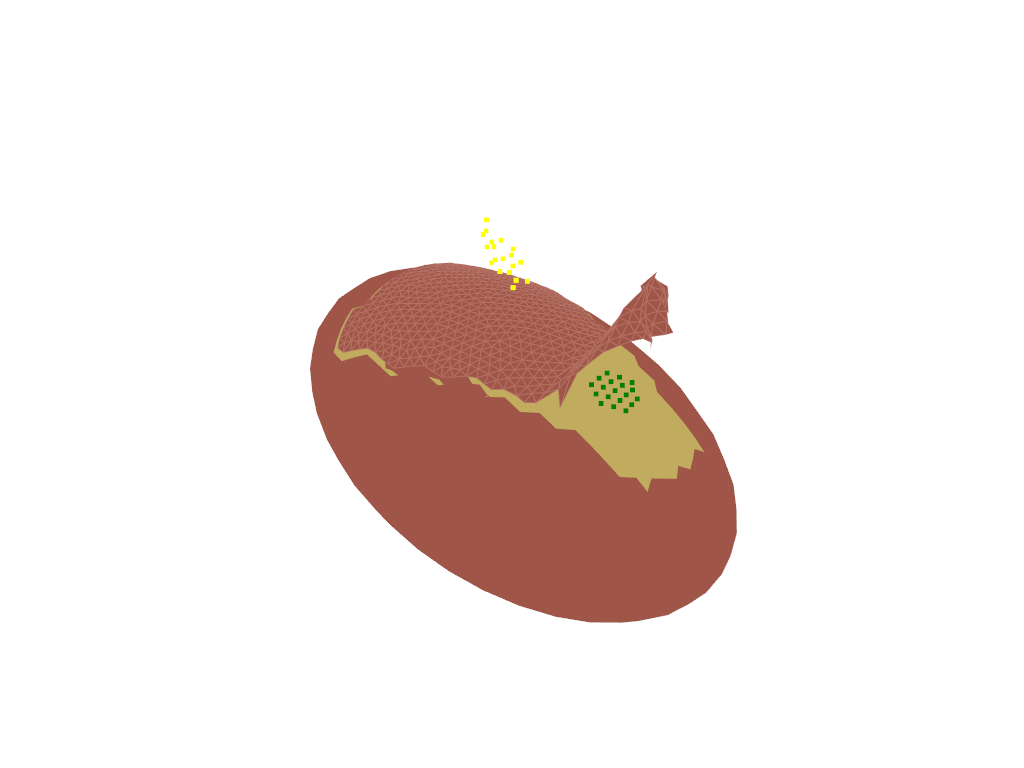

1
tensor(0.0356, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


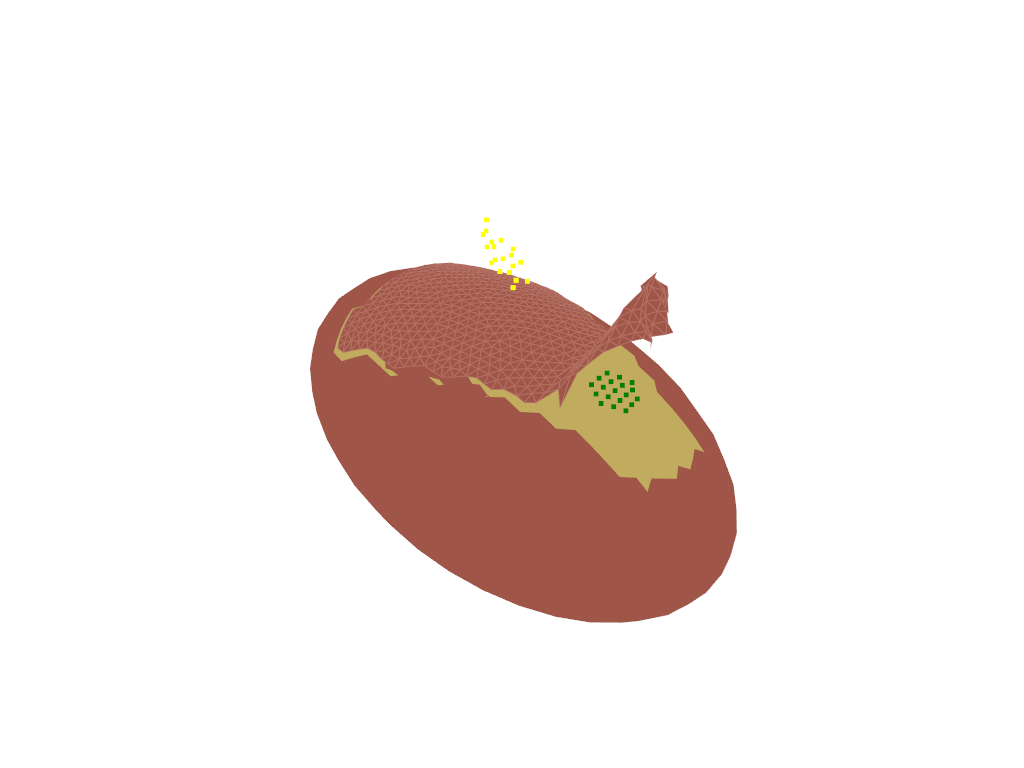

2
tensor(0.0334, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


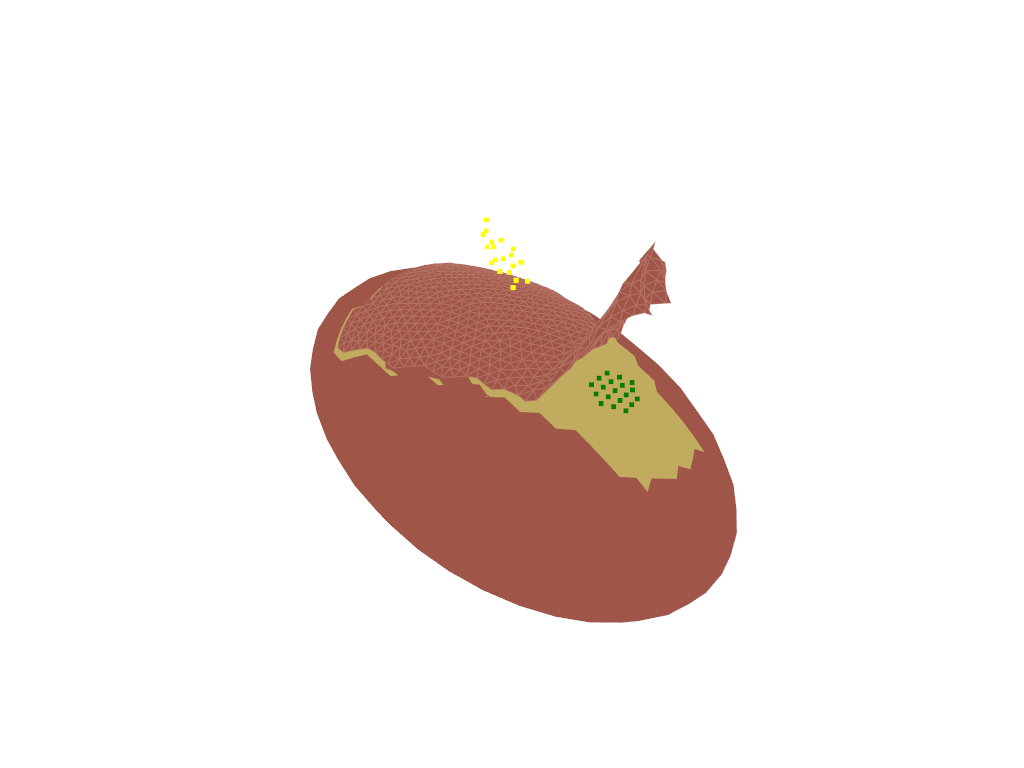

3
tensor(0.0312, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


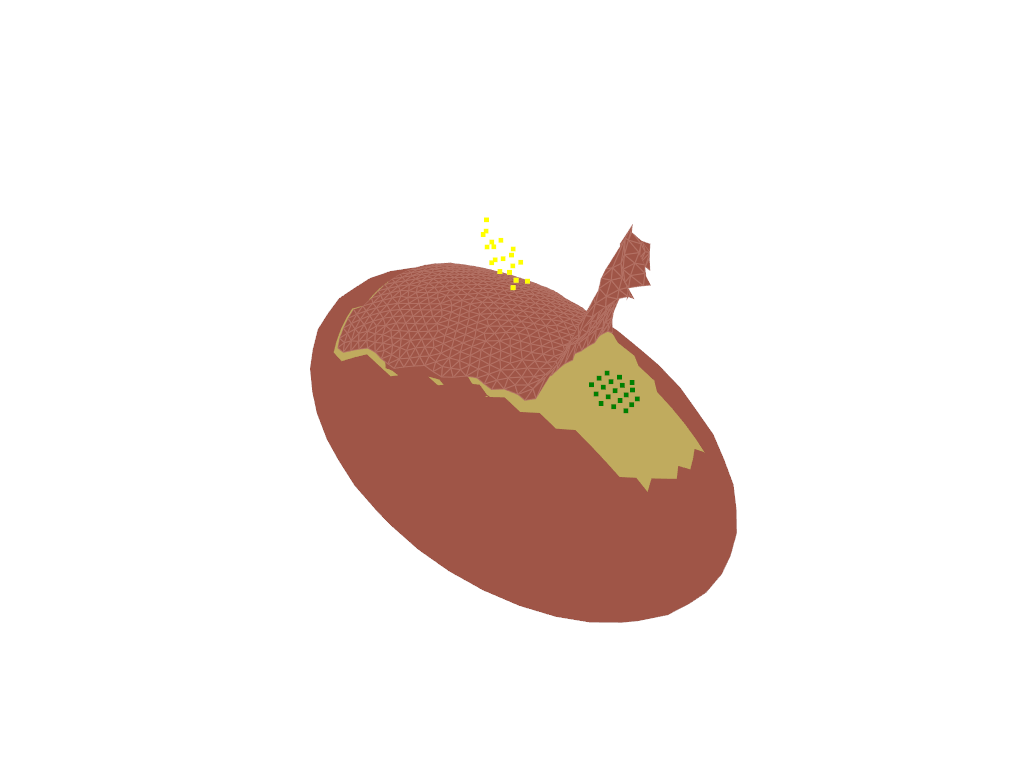

4
tensor(0.0290, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


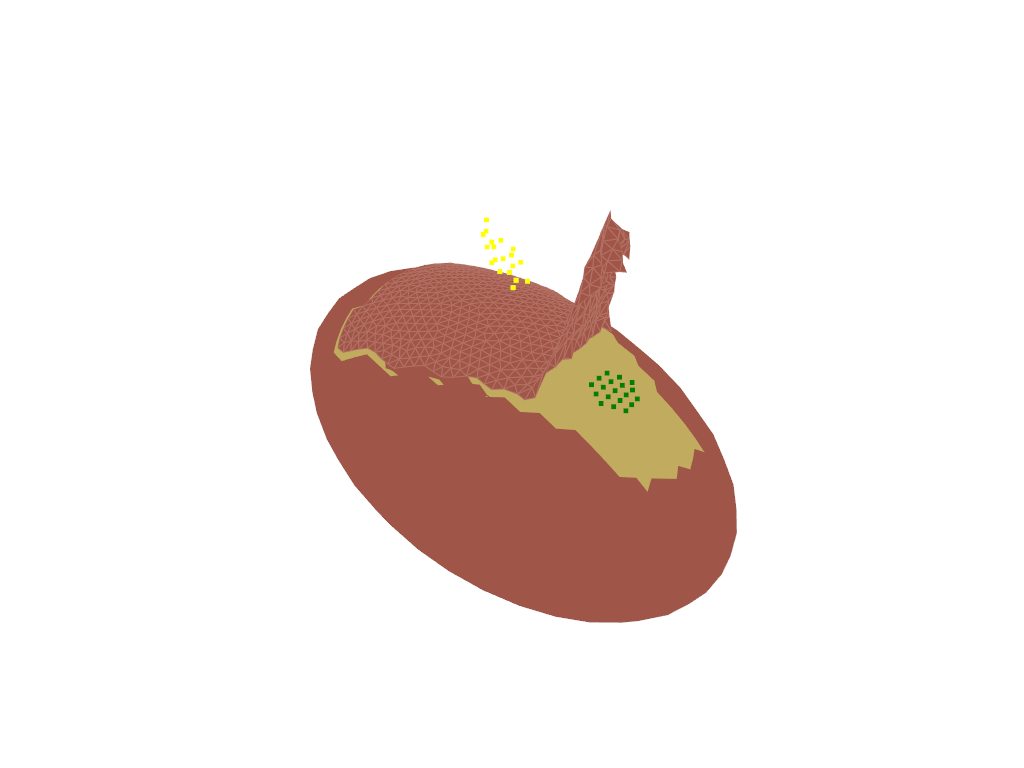

5
tensor(0.0270, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


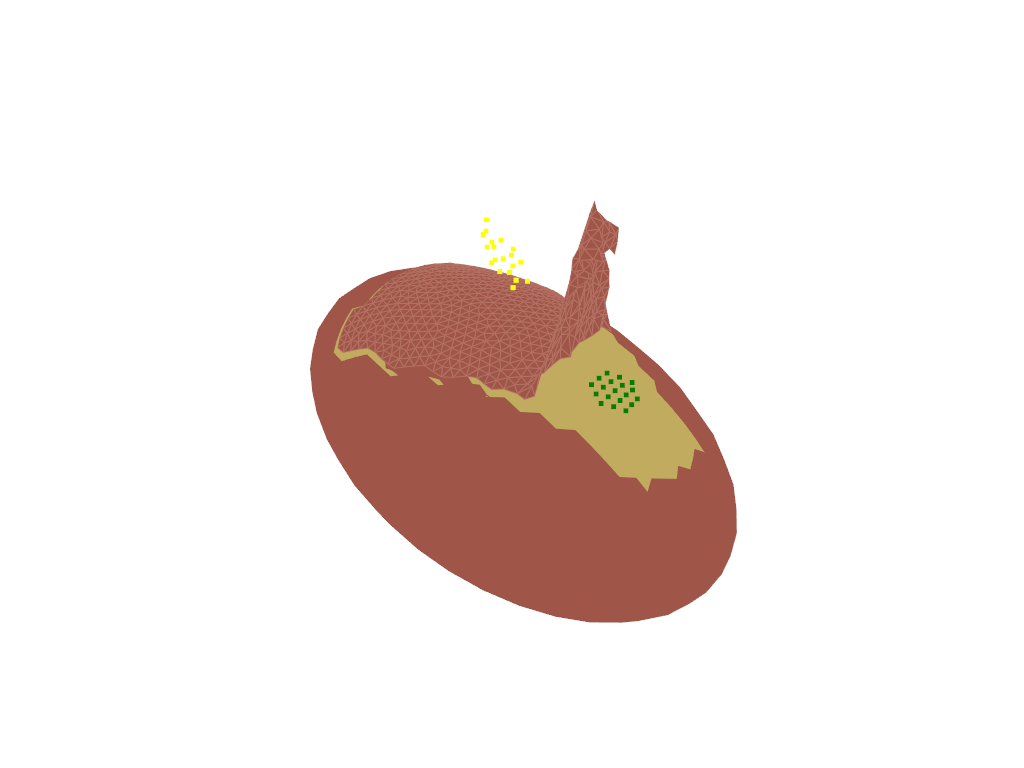

6
tensor(0.0242, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


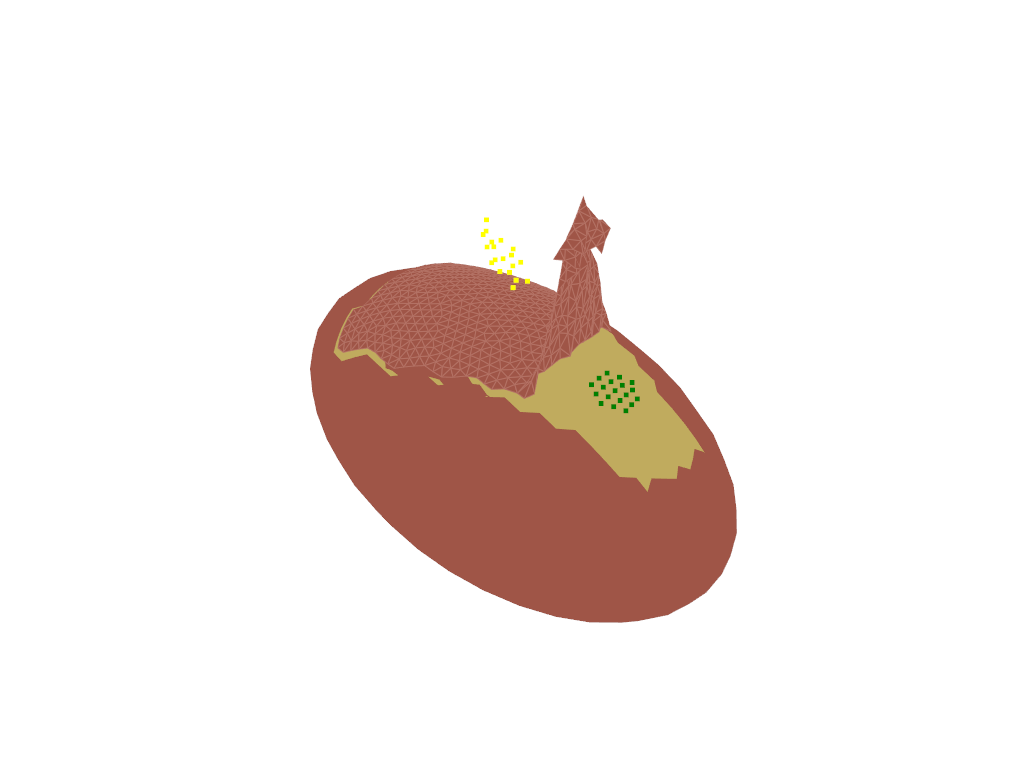

7
tensor(0.0215, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


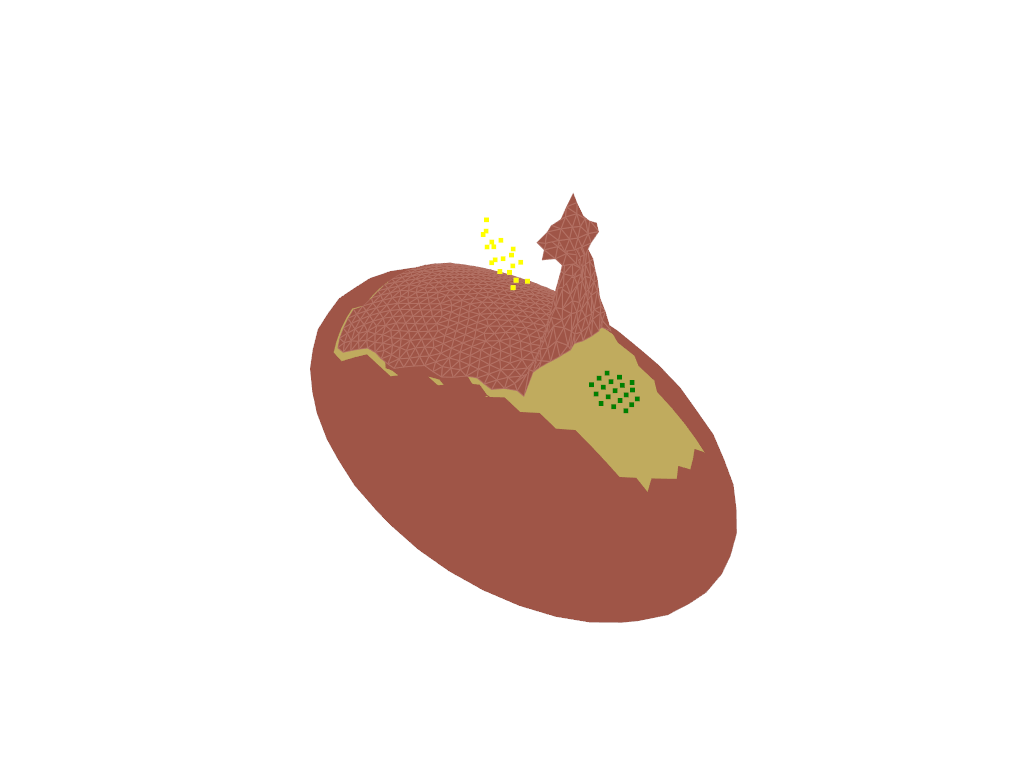

8
tensor(0.0192, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


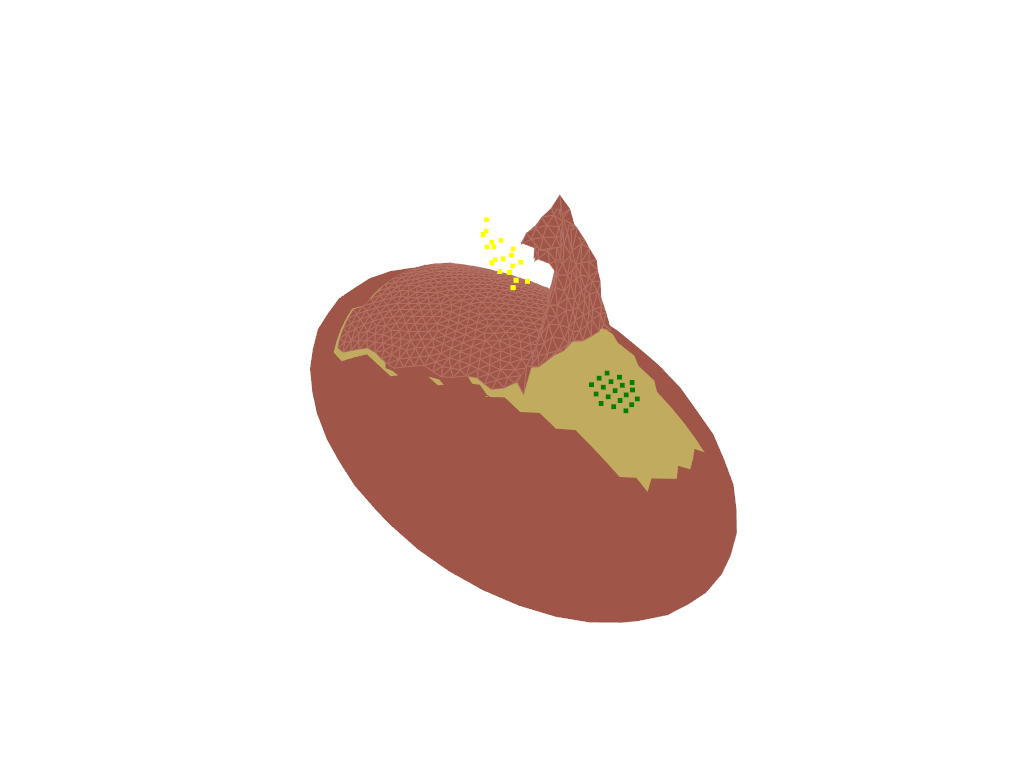

9
tensor(0.0171, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


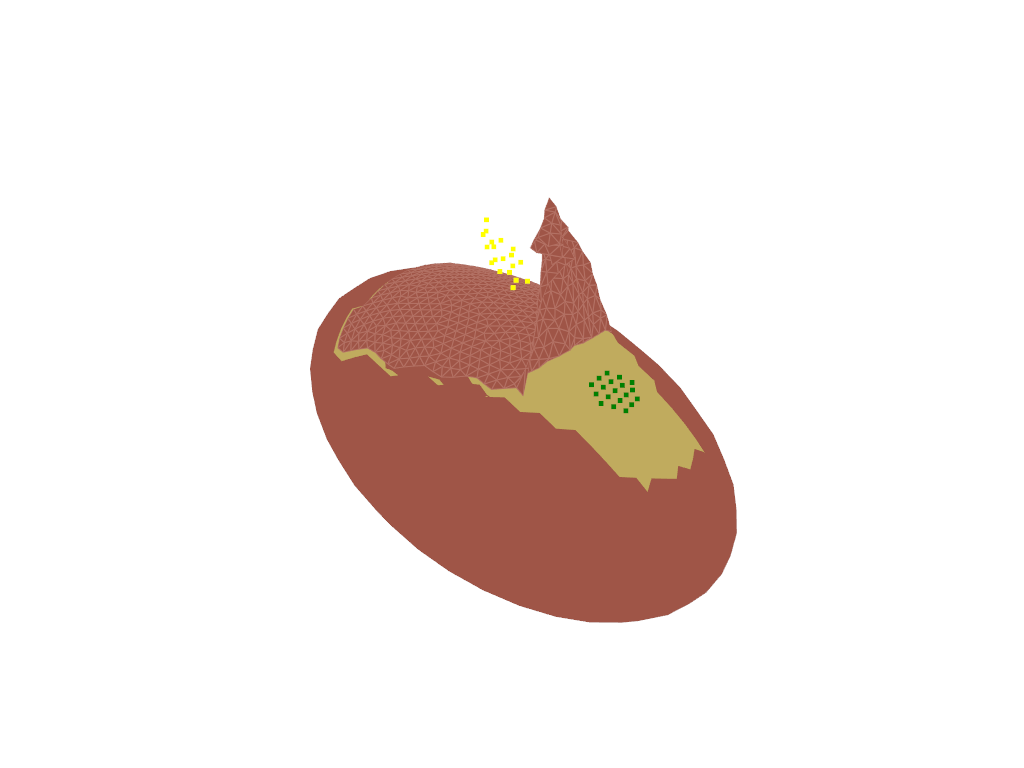

10
tensor(0.0149, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


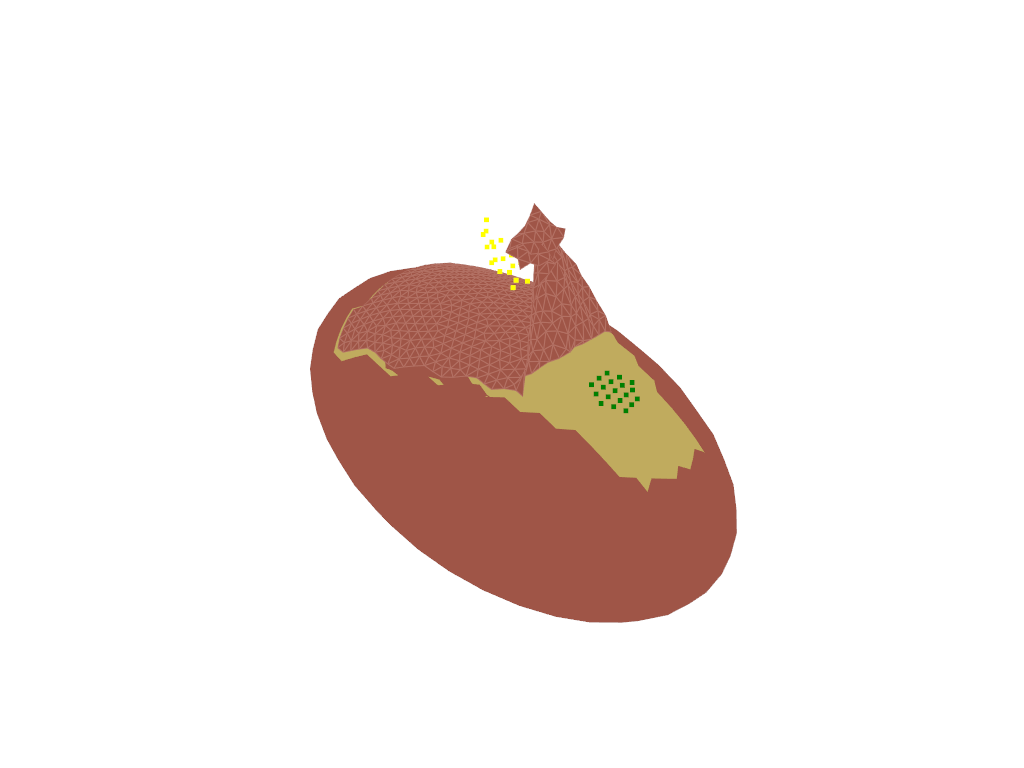

11
tensor(0.0122, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


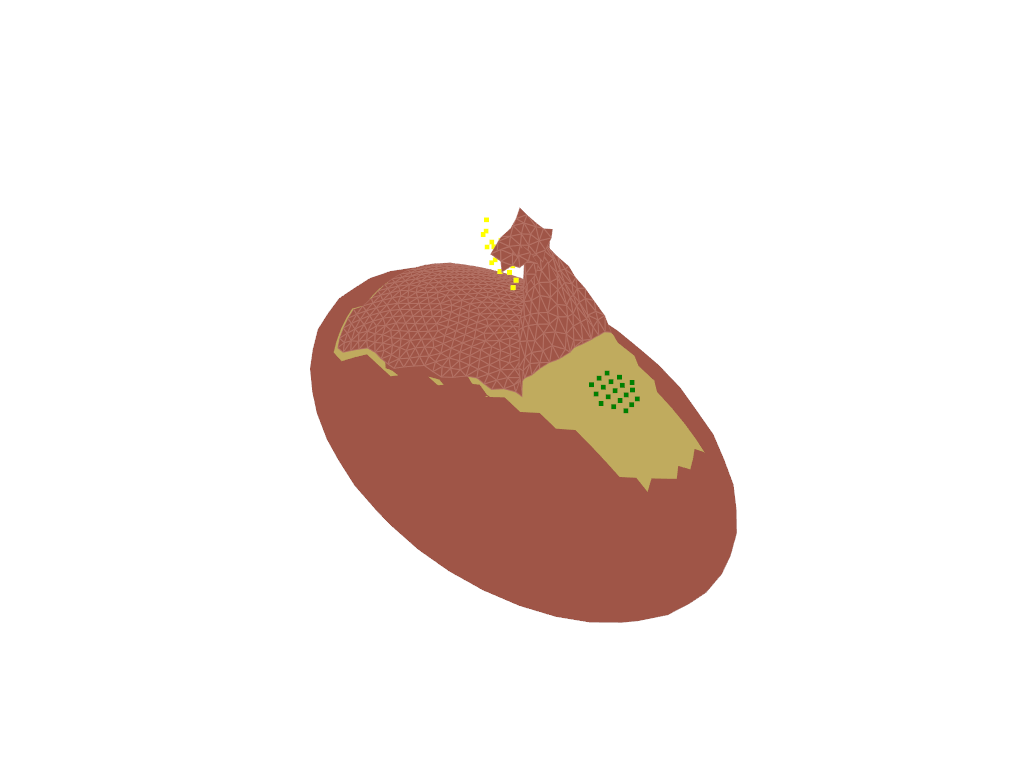

12
tensor(0.0094, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


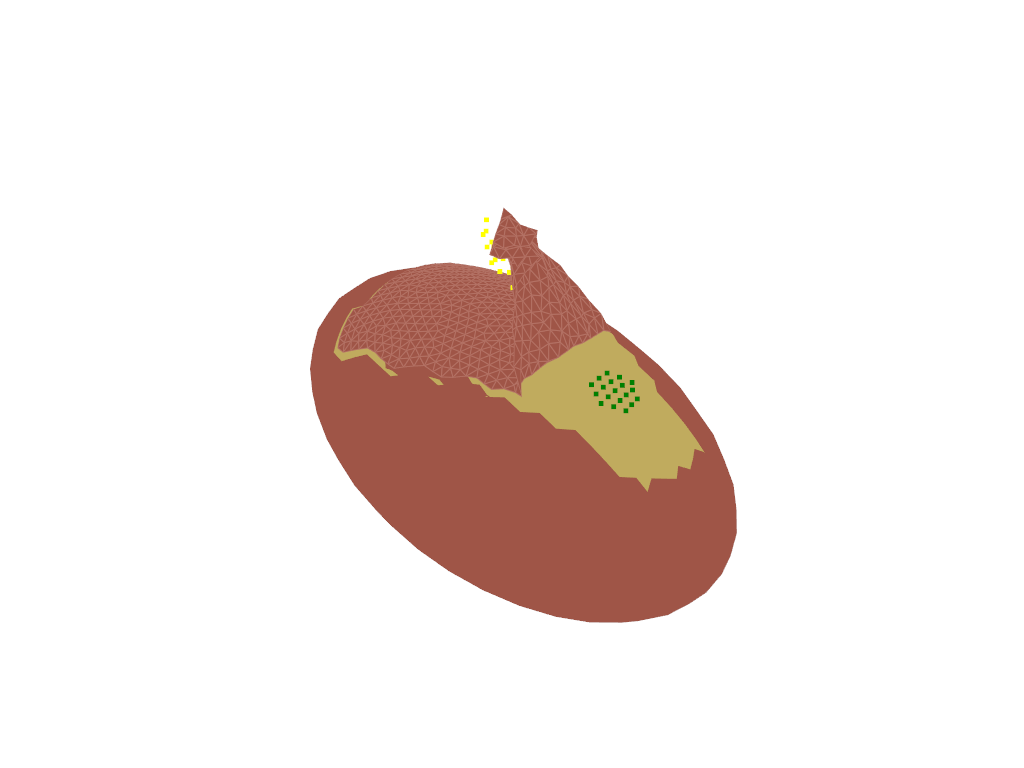

13
tensor(0.0064, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


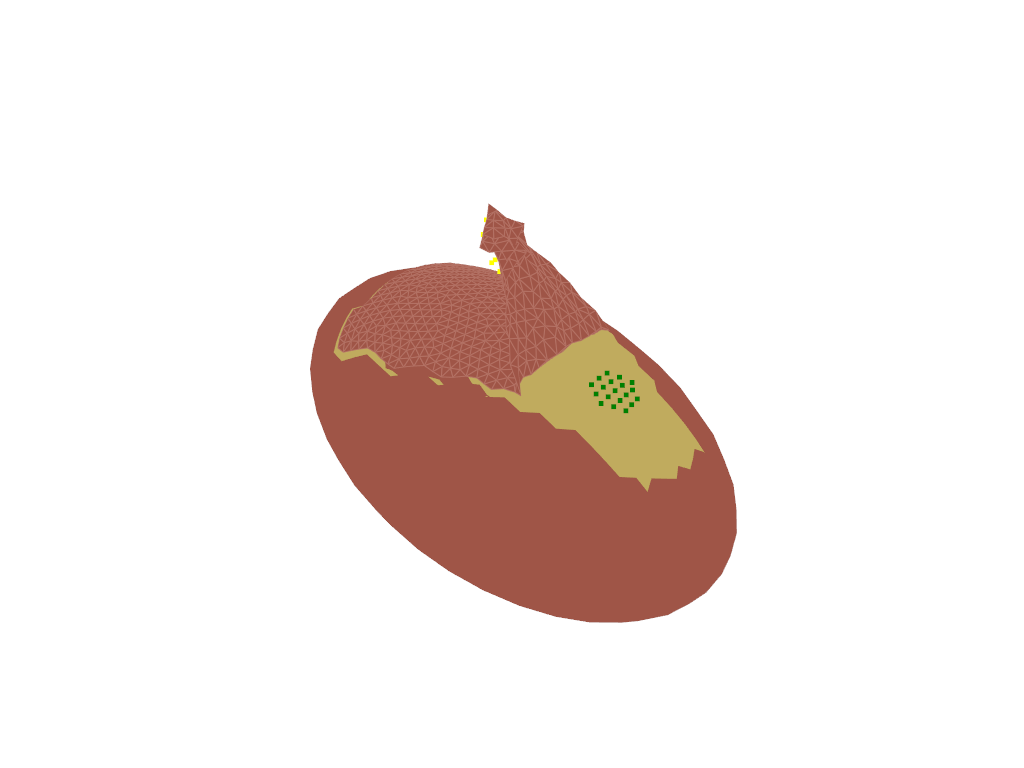

14
tensor(0.0030, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


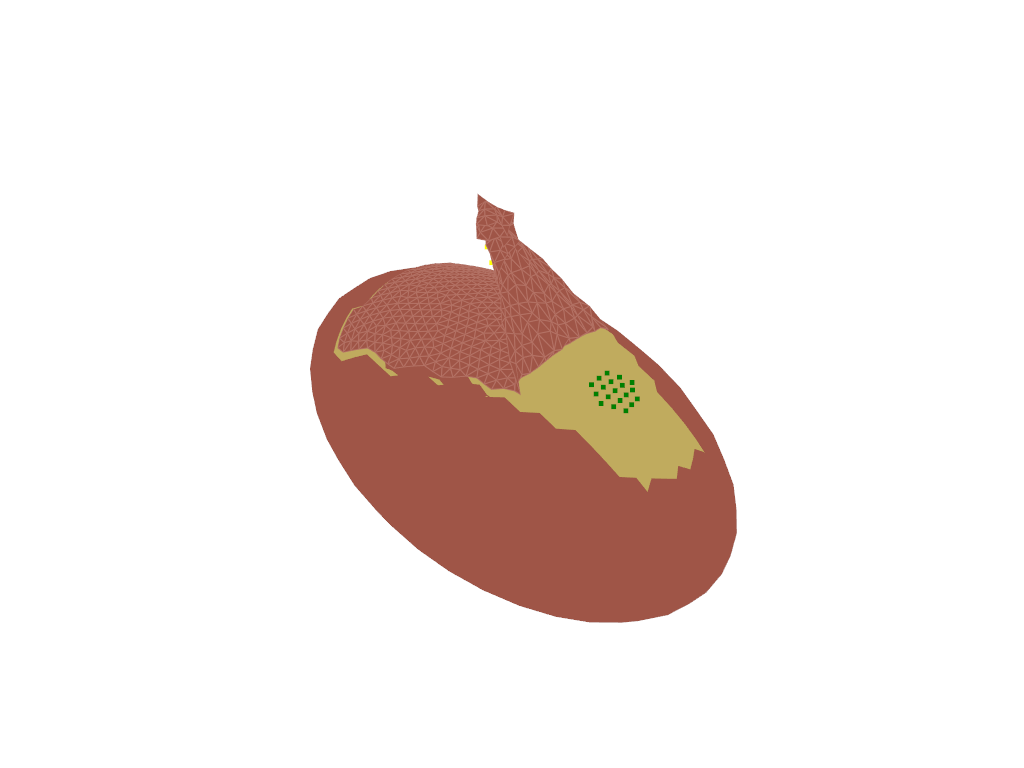

15
tensor(0.0018, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


In [26]:
control = []
loss_list = []
spline_list = []
pre_loss = 100
for t in range(1000):
    print(t)
    x_con = torch.cat((start_point[:, 0], spline_control[:, 0]))
    y_con = torch.cat((start_point[:, 1], spline_control[:, 1]))
    z_con = torch.cat((start_point[:, 2], spline_control[:, 2]))
    spline_x = interp(u, x_con, us)
    spline_y = interp(u, y_con, us)
    spline_z = interp(u, z_con, us)

    spline_trajectory = torch.transpose(torch.vstack((spline_x, spline_y, spline_z)), 0, 1)
    spline_list.append(spline_trajectory.detach().cpu().numpy())
    # reset for each test
    softbody.V = V_origin.clone()
    softbody.V_velocity = Velocity_origin.clone()

    cloth_dist_stiffness = 1
    V_boundary_stiffness = 0.1
    V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)
    V_boundary_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device) * V_boundary_stiffness
    
    for i in range(spline_trajectory.shape[0]):
        softbody.V[control_point] = spline_trajectory[i]
        step_ref = XPBDStep(softbody,
                        V_dist_stiffness=V_dist_stiffness, 
                        V_shape_stiffness=None,
                        V_boundary_stiffness=V_boundary_stiffness, 
                        dt=cfg.dt,
                        substep=cfg.substep,
                        iteration=cfg.iteration,
                        quasi_static=cfg.quasi_static,
                        plane_height=cfg.ground_plane_height, 
                        use_shape_matching=cfg.use_shape_matching,
                        use_spring_boundary=cfg.use_spring_boundary) #cfg.use_spring_boundary
        V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)
        softbody.V = V_ref.clone()
        softbody.V_velocity = V_velocity_ref.clone()
        energy = get_energy_boundary(softbody, softbody.V, V_boundary_stiffness)
        V_boundary_stiffness[:cfg.n_surf] = V_boundary_stiffness[:cfg.n_surf] * torch.sigmoid(1e9 * (1e-8 - energy))

    # interpolate trajectory
    
    loss = loss_fn(target_pos, V_ref[softbody.target_list])
    loss.backward()
    
    loss_list.append(loss.detach().cpu())
    print(loss)
    if loss.detach() < 0.002:
        break
    optimizer.step()
    optimizer.zero_grad()
    
    mesh.points = softbody.V.detach().cpu().numpy()
    pl.show(interactive_update=True)

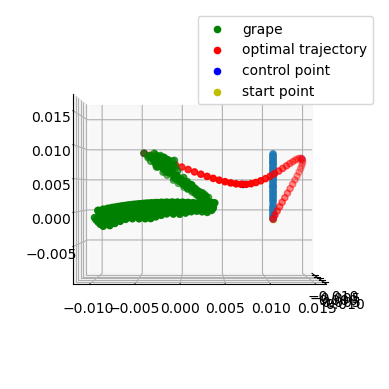

In [27]:
# interpolate trajectory
control = np.array(control)
mesh.points = softbody.V.detach().cpu().numpy()
x = np.arange(control_trajectory.shape[0])
xnew = np.linspace(x.min(), x.max(), control_trajectory.shape[0]*10)  # 10 times denser

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(mesh.points[:600, 0], mesh.points[:600, 1], mesh.points[:600, 2], c='g', marker='o', label='grape')
ax.scatter(spline_trajectory[:, 0].cpu().detach(), spline_trajectory[:, 1].cpu().detach(), spline_trajectory[:, 2].cpu().detach(), c='r', marker='o', label='optimal trajectory')
ax.scatter(spline_control[:, 0].cpu().detach(), spline_control[:, 1].cpu().detach(), spline_control[:, 2].cpu().detach(), c='b', marker='o', label='control point')
ax.scatter(start_point[:, 0].cpu().detach(), start_point[:, 1].cpu().detach(), start_point[:, 2].cpu().detach(), c='y', marker='o', label='start point')
ax.scatter(spline_list[0][:, 0], spline_list[0][:, 1], spline_list[0][:, 2])
utils.axisEqual3D(ax)
ax.view_init(elev=0, azim=0)
ax.legend()
plt.show()

In [28]:
spline_mesh = mesh.copy()

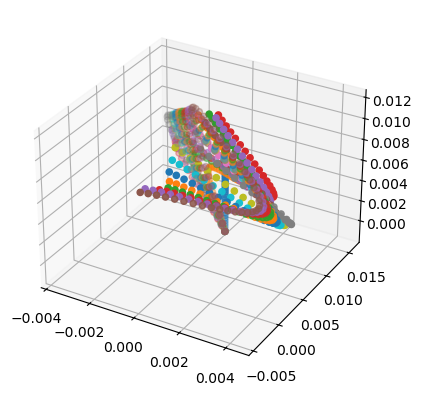

In [29]:
ax = plt.figure().add_subplot(projection='3d')
for i in spline_list:
    ax.scatter(i[:, 0], i[:, 1], i[:, 2], marker='o')

Text(0, 0.5, 'loss')

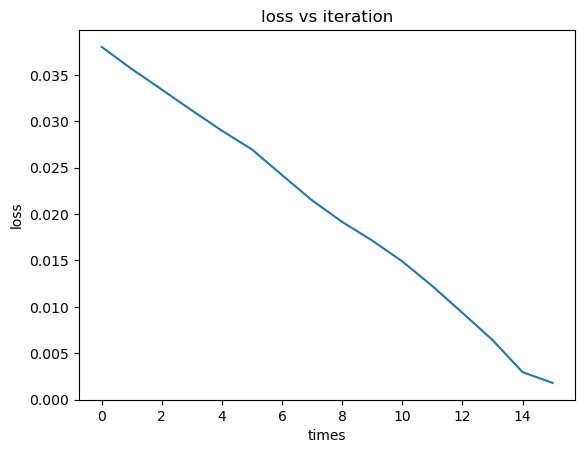

In [30]:
plt.plot(loss_list)
plt.title('loss vs iteration')
plt.xlabel('times')
plt.ylabel('loss')

In [31]:
spline_control

tensor([[-2.0959e-03,  1.4323e-02,  8.2421e-03],
        [ 2.5324e-03,  7.1984e-03,  4.1915e-03],
        [ 1.6047e-05, -4.3786e-03,  9.0813e-03]], device='cuda:0',
       dtype=torch.float64, requires_grad=True)

In [32]:
spline_line = spline_trajectory.detach().cpu().numpy()

In [33]:
target_list = softbody.target_list[0].cpu().numpy()

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


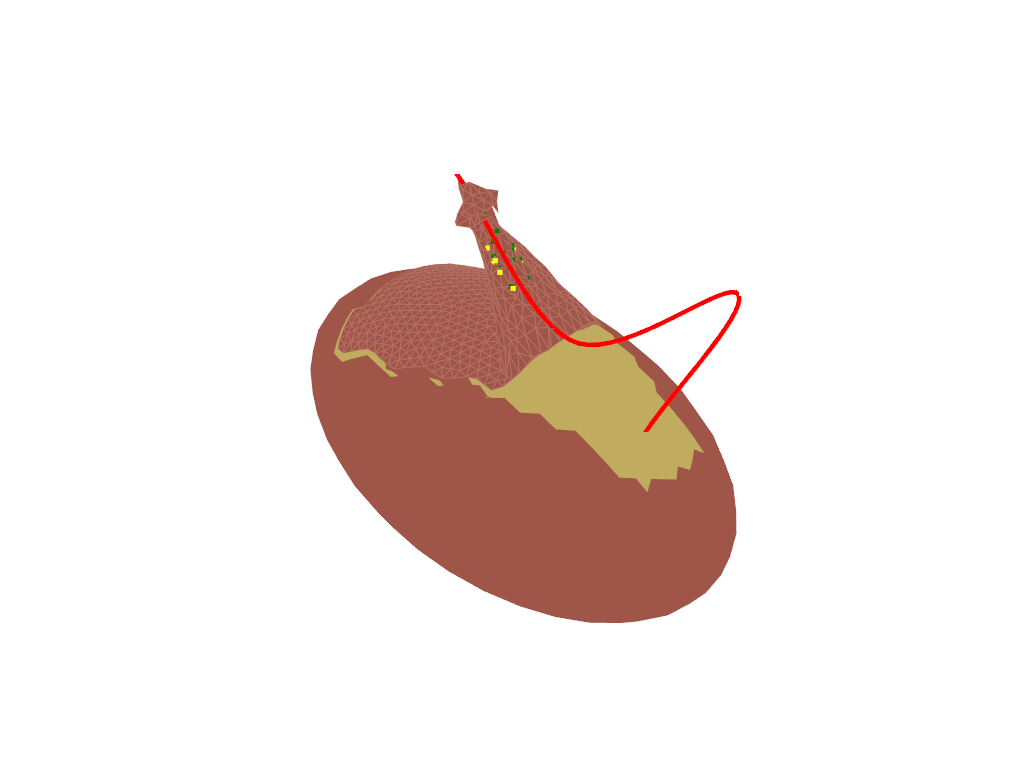

In [34]:
pv.set_plot_theme('document')
pl = pv.Plotter()

# skin being peeled
pl.add_mesh(spline_mesh, color='#9f5547ff', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface')
# add target area
pl.add_points(spline_mesh.points[target_list], color='g')
pl.add_points(target_mesh.points[target_list], color='y')
# control line
pl.add_lines(spline_line, color='r', connected=True)
# ellipsoid grape
grape = pv.read('assets/grape.ply')
grape.points = grape.points - np.array([0, 0, 1e-4])
pl.add_mesh(grape, color='#9f5547ff', show_edges=False, lighting=False,style='surface')

# grape meat that is green
grape_meat= pv.read('assets/grape_skin.ply')
grape_meat.points = grape_meat.points - np.array([0, 0, 2e-4])
pl.add_mesh(grape_meat, color='#c0ab5eff', show_edges=False, lighting=False,style='surface')
pl.show()